**EpiAnno** requires unified feature set between reference and query dataset. This is achieved bu *mapping* the reads of reference to those in query. In practice this means:
    
    1. get the features of query dataset
    2. for the reference dataset, count the # of reads falling into each of these features

- This results in unified feature-set. However this is somewhat problematic because this reference dataset is used as the training set in supervised learning setting. This means, the training data actually knows about the test set.

After obtaning this unified feature sets, the daat matrices are subjected to following normalization/processing steps:
    
    1. feature selection: keep only the features/peaks that have at least one read count in at least 3% of cells
    2. TF-IDF transformation: TF *  log (1 + inverse document frequency)
    3. z-normalization: normalize the TF-IDF-transformed scCAS data by making each peak centred and scaled (with zero mean and unit variance)
    
Some of these functions 


In [ ]:
import pickle
import pandas as pd
import sklearn
import numpy as np
import scanpy as sc
import scipy.sparse
import anndata
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
import copy
import logging as logg
from sklearn import preprocessing
import os 
import warnings
import scATAcat
import seaborn as sns
import random as rn 

warnings.filterwarnings('ignore')

In [ ]:
# set the seed for reproducibility
sd = 1234
np.random.seed(sd)
rn.seed(sd)
%env PYTHONHASHSEED=0


#### define necessary parameters

In [ ]:
results_dir = "../../../../data/Satpathy2019/PBMC_Rep1_scATAC/04_preprocessing_for_EpiAnno/"
output_dir = results_dir +"/outputs/"
figures_dir = results_dir +"/figures/"
data_dir = "../../../../data/Satpathy2019/PBMC_Rep1_scATAC/03_ENCODE_coverage_by_cell_matrix/"

for dir in [figures_dir, output_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)

### 0 - Load scATAC-seq data

In [ ]:
reference_ENCODE_coverage_per_cell_df= pickle.load(open(data_dir + 'GSM3722015_PBMC_Rep1_per_cell_encode_cCRE_matrix_sparse.pkl','rb'))


In [ ]:
reference_ENCODE_cCREs = pd.read_csv(data_dir +"GSM3722015_PBMC_Rep1_ENCODE_cCREs.csv", index_col=0)
reference_ENCODE_cCREs.index = reference_ENCODE_cCREs.iloc[:,0]
reference_ENCODE_cCREs.index.name = None
reference_ENCODE_cCREs.columns = ['cCREs']
reference_ENCODE_cCREs.head()

In [ ]:
reference_cell_IDs = pd.read_csv(data_dir +"cellIDs.csv", index_col=0)
reference_cell_IDs.index = reference_cell_IDs.iloc[:,0]
reference_cell_IDs.index.name = None
reference_cell_IDs.columns = ['cell_IDs']
reference_cell_IDs.head()

### 1 - initialize the AnnData object

In [ ]:
reference_sc_completeFeatures_adata = anndata.AnnData(reference_ENCODE_coverage_per_cell_df.transpose(), var=ENCODE_cCREs, obs=cell_IDs)


In [ ]:
reference_sc_completeFeatures_adata

### 2 - add binary layer to AnnData

In [ ]:
scATAcat.add_binary_layer(reference_sc_completeFeatures_adata, binary_layer_key="binary")

## 3- calculate & plot cell and feature statistics

In [ ]:
scATAcat.cell_feature_statistics(reference_sc_completeFeatures_adata, binary_layer_key ='binary')

In [ ]:
scATAcat.plot_feature_statistics(reference_sc_completeFeatures_adata, threshold=3, bins=50, color="lightgrey", save=True, save_dir = figures_dir +"/feature_statistics_plot.png")

In [ ]:
scATAcat.plot_cell_statistics(reference_sc_completeFeatures_adata, threshold=1000, bins=50, color="lightgrey", save=True, save_dir = figures_dir + "/cell_statistics_plot.png")

## 4- filter the cells and features

In [ ]:
reference_sc_completeFeatures_adata

In [ ]:
int(reference_sc_completeFeatures_adata.shape[0]*3/100)

In [ ]:
reference_sc_filteredFeatures_adata = scATAcat.preproces_sc_matrix(reference_sc_completeFeatures_adata,cell_cutoff=0,cell_cutoff_max=80000, feature_cutoff=int(reference_sc_completeFeatures_adata.shape[0]*3/100), remove_chrY = True, var_key = 'cCREs', copy=True)

In [ ]:
reference_sc_filteredFeatures_adata

## do until this step also with the query data anbd re-unify the features as afytr filtering step the feature sets might be the same:

In [ ]:
scATAC_analysis/scATAcat_notebooks_for_paper/jan2024/data/10X_PBMC_scmultiome

In [3]:
results_dir_query = "../../../../data/Satpathy2019/PBMC_Rep1_scATAC/04_preprocessing_for_EpiAnno/"
output_dir_query = results_dir+"/outputs_query/"
figures_dir_query = results_dir+"/figures_query/"
data_dir_query = "../../../../../scATAcat_notebooks_for_paper/jan2024/data/"

for dir in [figures_dir, output_dir]:
    if not os.path.exists(dir):
        os.mkdir(dir)


### 0 - Load scATAC-seq data

In [4]:
ENCODE_coverage_per_cell_df= pickle.load(open(data_dir + '10X_PBMC_scmultiome/02_ENCODE_coverage_by_cell_matrix/PBMC_ENCODE_coverage_per_cell_matrix_sparse.pkl','rb'))


In [5]:
ENCODE_coverage_per_cell_df

<926535x10411 sparse matrix of type '<class 'numpy.float32'>'
	with 123604223 stored elements in Compressed Sparse Row format>

In [6]:
ENCODE_cCREs = pd.read_csv(data_dir +"10X_PBMC_scmultiome/02_ENCODE_coverage_by_cell_matrix/ENCODE_coverage_per_cell_ENCODE_cCREs.csv", index_col=0)
ENCODE_cCREs.columns = ["cCREs"]
ENCODE_cCREs.index = ENCODE_cCREs['cCREs']
ENCODE_cCREs.head()

,cCREs
cCREs,
chr1_181251_181601,chr1_181251_181601
chr1_190865_191071,chr1_190865_191071
chr1_778562_778912,chr1_778562_778912
chr1_779086_779355,chr1_779086_779355
chr1_779727_780060,chr1_779727_780060


In [7]:
cell_IDs = pd.read_csv(data_dir +"10X_PBMC_scmultiome/02_ENCODE_coverage_by_cell_matrix/ENCODE_coverage_per_cell_cell_IDs.csv", index_col=0)
cell_IDs.columns = ["cell_IDs"]
cell_IDs.index = cell_IDs["cell_IDs"]
cell_IDs.head()

,cell_IDs
cell_IDs,
AAACAGCCAATCCCTT-1,AAACAGCCAATCCCTT-1
AAACAGCCAATGCGCT-1,AAACAGCCAATGCGCT-1
AAACAGCCACCAACCG-1,AAACAGCCACCAACCG-1
AAACAGCCAGGATAAC-1,AAACAGCCAGGATAAC-1
AAACAGCCAGTAGGTG-1,AAACAGCCAGTAGGTG-1


### 1 - initialize the AnnData object

In [8]:
sc_completeFeatures_adata = anndata.AnnData(ENCODE_coverage_per_cell_df.transpose(), var=ENCODE_cCREs, obs=cell_IDs)


In [9]:
sc_completeFeatures_adata

AnnData object with n_obs × n_vars = 10411 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'

### 2 - add binary layer to AnnData

In [10]:
scATAcat.add_binary_layer(sc_completeFeatures_adata, binary_layer_key="binary")

AnnData object with n_obs × n_vars = 10411 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    layers: 'binary'

## 3- calculate & plot cell and feature statistics

In [11]:
scATAcat.cell_feature_statistics(sc_completeFeatures_adata, binary_layer_key ='binary')

AnnData object with n_obs × n_vars = 10411 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

AnnData object with n_obs × n_vars = 10411 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

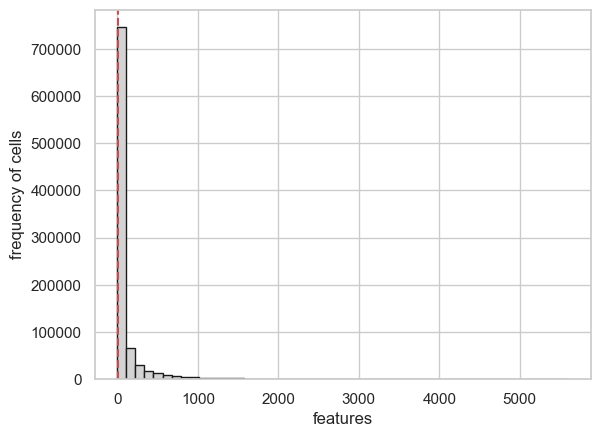

In [12]:
scATAcat.plot_feature_statistics(sc_completeFeatures_adata, threshold=3, bins=50, color="lightgrey", save=True, save_dir = figures_dir +"/feature_statistics_plot.png")

AnnData object with n_obs × n_vars = 10411 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

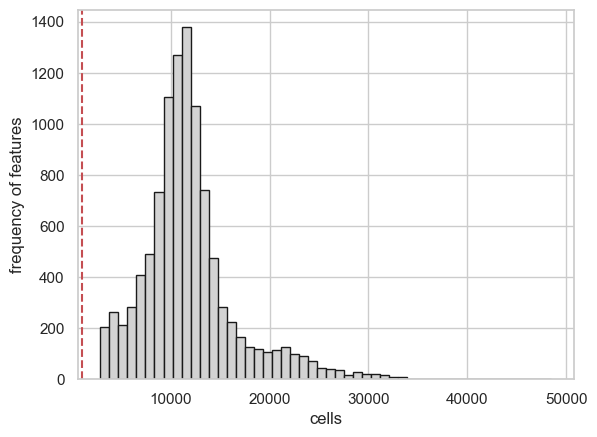

In [13]:
scATAcat.plot_cell_statistics(sc_completeFeatures_adata, threshold=1000, bins=50, color="lightgrey", save=True, save_dir = figures_dir + "/cell_statistics_plot.png")

## 4- filter the cells and features

In [14]:
sc_completeFeatures_adata

AnnData object with n_obs × n_vars = 10411 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

In [15]:
sc_filteredFeatures_adata = scATAcat.preproces_sc_matrix(sc_completeFeatures_adata,cell_cutoff=1000,cell_cutoff_max=80000, feature_cutoff=3, remove_chrY = True, var_key = 'cCREs', copy=True)

In [16]:
sc_filteredFeatures_adata

View of AnnData object with n_obs × n_vars = 10411 × 742148
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'